# Schedulers in PyTorch

Welcome to this exploration of learning rate schedulers in PyTorch! As you have learned in the lectures, managing learning rates is vital to optimizing model training, and PyTorch provides various tools to streamline this process. Learning rate schedulers are essential for dynamically adjusting learning rates according to the training phase, helping to facilitate faster convergence and improve generalization.

In this notebook, you will dive into the mechanics of different learning rate schedulers. Specifically, you will:

* Explore how schedulers like `StepLR`, `CosineAnnealingLR`, and `ReduceLROnPlateau` adjust the learning rate to maintain training efficiency.

* Use these schedulers within a typical training loop.

* Learn to visualize training dynamics, demonstrating the impact of schedulers on model performance compared to a constant learning rate.

By the end of this notebook, you will have practical experience in applying learning rate schedulers, enhancing your understanding of their role in model training.

In [1]:
import sys
import time
import warnings

# Redirect stderr to a black hole to catch other potential messages
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import helper_utils

helper_utils.set_seed(42)

In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## A deeper dive into the training process

In this section you will make a deeper analysis of the experiments we have done in the previous lab. 
You will use a simple model (`SimpleCNN`) and the CIFAR-10 dataset, but now we will inspect the training process more closely by plotting the **training loss** and **validation accuracy** curves.

This will help use understand how the model learns over time and how different learning rates affect the training dynamics.

In the following cell we find `SimpleCNN` model definition, and `evaluate_epoch` function that you can use to evaluate the model on the validation set *after each epoch*.
`train_and_evaluate` function is provided to train the model for a specified number of epochs and evaluate it during training.

`get_data_loaders`and `train_epoch` functions are provided from `helper_utils` module. 
They are used to load the CIFAR-10 dataset and train the model for one epoch, respectively.

In [4]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """
    def __init__(self):
        """Initializes the layers of the neural network."""
        # Initialize the parent nn.Module class
        super(SimpleCNN, self).__init__()
        # First convolutional layer (3 input channels, 16 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer (16 input channels, 32 output channels, 3x3 kernel)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # First fully connected (linear) layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Second fully connected (linear) layer, serving as the output layer
        self.fc2 = nn.Linear(64, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final output layer
        x = self.fc2(x)
        return x


def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128, p_bar=None):
    """Orchestrates the training and evaluation of a model for a given configuration.

    This function handles the end-to-end workflow: setting a random seed,
    initializing the model, optimizer, loss function, and dataloaders, and then
    running the main training loop.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        p_bar (optional): An existing progress bar handler. Defaults to None.

    Returns:
        dict: A dictionary containing the training and validation history
              (loss and accuracy).
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Prepare the training and validation dataloaders
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Call the main training loop to train the model and get the history
    history = helper_utils.train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fcn=loss_fn,
        device=device,
        n_epochs=n_epochs,
        p_bar=p_bar
    )

    # Return the collected training history
    return history

Now the model is trained for several epochs for each of the specified learning rates.
The results are stored in `training_curves`, and the curves (train loss and validation accuracy) are plotted for each learning rate.

In [5]:
# Different learning rates to be analyzed
learning_rates = [0.0002, 0.001, 0.005] # Small, medium, and large learning rates

training_curves = []
n_epochs = 25
batch_size = 128

p_bar = helper_utils.get_p_bar(n_epochs)

# Get the total number of learning rates to check against the index
num_learning_rates = len(learning_rates)

# Train and evaluate the model for each learning rate
for i, lr in enumerate(learning_rates):
    print(f"\nTraining with learning rate: {lr}\n")
    history = train_and_evaluate(learning_rate=lr, n_epochs=n_epochs, batch_size=batch_size, device=device, p_bar=p_bar)
    training_curves.append(history)
    # Only reset the progress bar if it's NOT the last iteration
    if i < num_learning_rates - 1:
        p_bar.reset()

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/10 [00:00<?, ?it/s]


Training with learning rate: 0.0002



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.7613, Training accuracy: 0.3693
At epoch 5: Validation loss: 1.6630, Validation accuracy: 0.4150


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.5489, Training accuracy: 0.4506
At epoch 10: Validation loss: 1.4998, Validation accuracy: 0.4720


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.4556, Training accuracy: 0.4720
At epoch 15: Validation loss: 1.4369, Validation accuracy: 0.4925


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.3760, Training accuracy: 0.5011
At epoch 20: Validation loss: 1.3789, Validation accuracy: 0.5145


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 1.3216, Training accuracy: 0.5205
At epoch 25: Validation loss: 1.3449, Validation accuracy: 0.5240
Training complete


Training with learning rate: 0.001



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4854, Training accuracy: 0.4626
At epoch 5: Validation loss: 1.4158, Validation accuracy: 0.4930


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.2907, Training accuracy: 0.5415
At epoch 10: Validation loss: 1.3005, Validation accuracy: 0.5400


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.1614, Training accuracy: 0.5793
At epoch 15: Validation loss: 1.2250, Validation accuracy: 0.5595


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.0294, Training accuracy: 0.6189
At epoch 20: Validation loss: 1.1862, Validation accuracy: 0.5880


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.9021, Training accuracy: 0.6690
At epoch 25: Validation loss: 1.2067, Validation accuracy: 0.5825
Training complete


Training with learning rate: 0.005



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4314, Training accuracy: 0.4769
At epoch 5: Validation loss: 1.3716, Validation accuracy: 0.5000


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1970, Training accuracy: 0.5651
At epoch 10: Validation loss: 1.3045, Validation accuracy: 0.5560


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.0207, Training accuracy: 0.6231
At epoch 15: Validation loss: 1.3592, Validation accuracy: 0.5480


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.9107, Training accuracy: 0.6542
At epoch 20: Validation loss: 1.3930, Validation accuracy: 0.5525


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.7827, Training accuracy: 0.6986
At epoch 25: Validation loss: 1.5255, Validation accuracy: 0.5430
Training complete



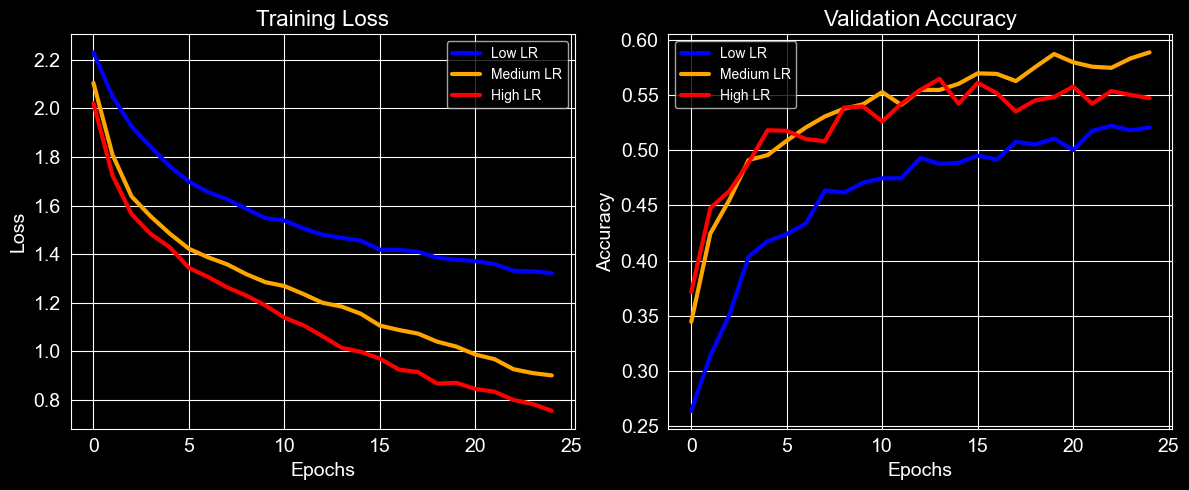

In [6]:
colors = ['blue', 'orange', 'red']
labels = ['Low LR', 'Medium LR', 'High LR']

helper_utils.plot_learning_curves(colors, labels, training_curves)

# Each color corresponds to a different learning rate: blue for low, orange for medium, and red for high.

### Learning Rate Analysis

Each color represents a different learning rate: blue for low, orange for medium, and red for high.

- **Low Learning Rate:**
The validation accuracy improves gradually and may require a significant amount of time (many epochs) to reach its peak.
- **Medium Learning Rate:**
The validation accuracy increases quickly, and by the end of the 25 epochs, it is outperforming the other two models.
- **High Learning Rate:**
Initially, validation accuracy is the highest during the first few epochs but eventually levels off, indicating instability where the model struggles to improve with such a high learning rate.

Among these options, the medium learning rate strikes the best balance between learning speed and generalization. Could you achieve a better model by combining these learning rates—starting with a high rate for the first few epochs, then transitioning to medium, and finally to low?

## Schedulers
In the previous section, you explored how the choice of learning rate impacts model performance. A high learning rate can lead to instability, while a low one might slow down training or yield suboptimal outcomes. Learning rate schedulers offer a solution by automatically adjusting the learning rate throughout training, initially setting it high for rapid learning and then reducing it to enhance convergence and generalization.

In this lab, you'll investigate three different schedulers. Let's start with the `StepLR` scheduler, which lowers the learning rate by a specified factor at regular intervals—specifically, after a set number of epochs. You'll repeat the training process from before, but this time you'll employ a scheduler that decreases the learning rate by a factor of 0.2 every 10 epochs.

In [7]:
helper_utils.set_seed(42)

# Initialize the model, optimizer, loss function, and dataloaders
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005) # start with a high learning rate

Schedulers are built into the PyTorch `torch.optim.lr_scheduler` module and can be easily integrated into your training loop.
You typically initialize a scheduler with the optimizer and parameters that define how the learning rate changes over time.

The `StepLR` scheduler, for example:
  - Takes the optimizer as input.
  - Requires `step_size`, the number of epochs before reducing the learning rate.
  - Uses a `gamma` factor, the factor by which the learning rate is reduced.

In [8]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2) # reduce the learning rate to 20% it's prior value

The training process is similar to the previous one, but the learning rate is adjusted by the scheduler after each epoch using the `scheduler.step()` method.
The current learning rate can be accessed using `scheduler.get_last_lr()`.

The model is trained for several epochs with the `StepLR` scheduler, and the training curves are plotted to compare the results with the previous experiments for the medium learning rate.

In [9]:
loss_fn = nn.CrossEntropyLoss()

train_loader, val_loader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

history_LR = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": [],
}


pbar = helper_utils.NestedProgressBar(
    total_epochs=n_epochs,
    total_batches=len(train_loader),
    epoch_message_freq=5,
    mode="train",
)

for epoch in range(n_epochs):
    pbar.update_epoch(epoch+1)

    # Train the model for one epoch
    train_loss, train_acc = helper_utils.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)

    # Evaluate the model on the validation set
    val_loss, val_acc = helper_utils.evaluate_epoch(model, val_loader, loss_fn, device)


    # Step the scheduler
    scheduler.step()
    # Get the current learning rate
    current_lr = scheduler.get_last_lr()[0]

    
    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

    history_LR["train_loss"].append(train_loss)
    history_LR["train_acc"].append(train_acc)
    history_LR["val_loss"].append(val_loss)
    history_LR["val_acc"].append(val_acc)
    history_LR["lr"].append(current_lr)

pbar.close('Training complete with StepLR scheduler')

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4265, Training accuracy: 0.4728, LR: 0.005000
At epoch 5: Validation loss: 1.3734, Validation accuracy: 0.5085


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1850, Training accuracy: 0.5637, LR: 0.001000
At epoch 10: Validation loss: 1.3351, Validation accuracy: 0.5240


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.9707, Training accuracy: 0.6452, LR: 0.001000
At epoch 15: Validation loss: 1.2687, Validation accuracy: 0.5650


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.9111, Training accuracy: 0.6601, LR: 0.000200
At epoch 20: Validation loss: 1.2903, Validation accuracy: 0.5705


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.8548, Training accuracy: 0.6815, LR: 0.000200
At epoch 25: Validation loss: 1.3028, Validation accuracy: 0.5745
Training complete with StepLR scheduler


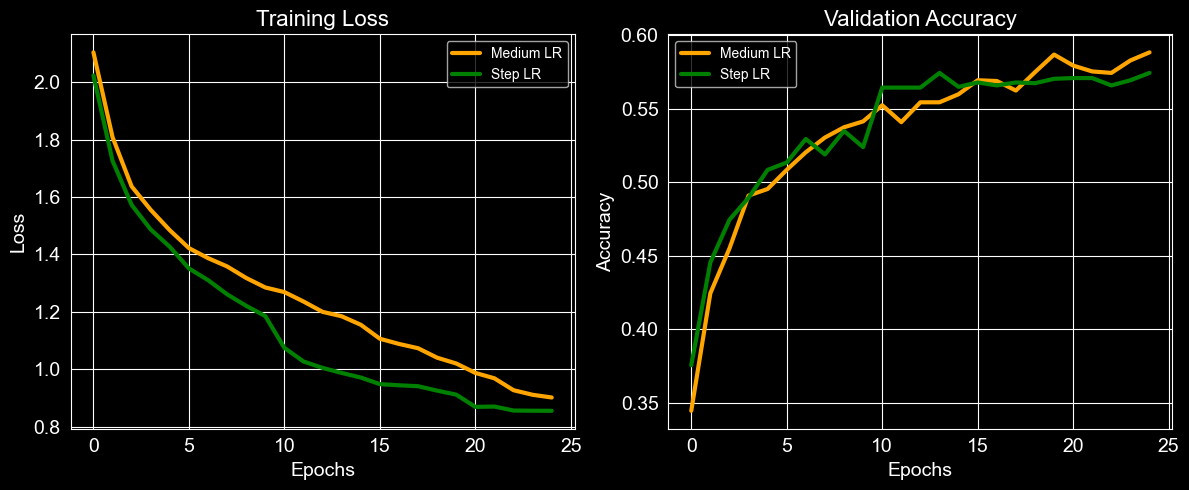

In [10]:
idx = 1
history_constant = training_curves[idx]

colors = ['orange', 'green']
labels = ['Medium LR', 'Step LR']
histories = [history_constant, history_LR]

helper_utils.plot_learning_curves(colors, labels, histories)

### Analysis of Medium LR and StepLR Scheduler

The plots show a comparison between training with a constant learning rate (orange) and using a `StepLR` scheduler (green). With StepLR, the training loss is significantly lower than with a fixed learning rate. You can also notice a few dips at the epoch 10 and 20 when the learning rate changes.  Although the validation accuracy starts off stronger, both models eventually converge to similar performance levels at the last epoch. Now, let's examine two more schedulers to compare their effectiveness.

### Other schedulers

There are many other schedulers available in PyTorch, such as `CosineAnnealingLR`, and `ReduceLROnPlateau`, each with its own strategy for adjusting the learning rate.
You can explore these options in the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

Below `train_and_evaluate_with_scheduler` function extends the previous `train_and_evaluate` function to include a learning rate scheduler.

In [11]:
def train_and_evaluate_with_scheduler(model, optimizer, scheduler, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model using a learning rate scheduler.

    Args:
        model: The neural network model to be trained.
        optimizer: The optimization algorithm.
        scheduler: The learning rate scheduler.
        device: The computing device ('cuda' or 'cpu') to run the training on.
        n_epochs: The total number of training epochs.
        batch_size: The number of samples per batch in the data loaders.

    Returns:
        A dictionary containing the training and validation history
        (loss, accuracy, and learning rate) for each epoch.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(10)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Prepare the training and validation data loaders
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Initialize a dictionary to store training and validation history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        'lr': [],
    }

    # Initialize the progress bar for monitoring training
    pbar = helper_utils.NestedProgressBar(
        total_epochs=n_epochs,
        total_batches=len(train_loader),
        epoch_message_freq=5,
        mode="train",
    )

    # Loop through the specified number of epochs
    for epoch in range(n_epochs):

        # Update the progress bar for the current epoch
        pbar.update_epoch(epoch+1)

        # Train the model for one epoch
        train_loss, train_acc = helper_utils.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)
        # Evaluate the model on the validation set
        val_loss, val_acc = helper_utils.evaluate_epoch(model, val_loader, loss_fn, device)

        # Update the learning rate based on the scheduler type
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # For schedulers that monitor a metric, pass the metric to the step function
            scheduler.step(val_acc)
        else:
            # For other schedulers, call the step function without arguments
            scheduler.step()
        
        # Retrieve the current learning rate from the scheduler
        current_lr = scheduler.get_last_lr()[0]

        # Log the training metrics for the current epoch, including the learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

        # Log the validation metrics for the current epoch, including the learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

        # Append the metrics for the current epoch to the history dictionary
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history['lr'].append(current_lr)

    # Close the progress bar upon completion of training
    pbar.close('Training complete!')
    # Return the collected training and validation history
    return history

<br>

In the following cells, you will run experiments using both `CosineAnnealingLR` and `ReduceLROnPlateau` schedulers. The training curves for each scheduler will be generated and compared to visualize their effects on model performance.

- **CosineAnnealingLR:**  
    This scheduler adjusts the learning rate following a cosine curve, gradually reducing it from the initial value to a minimum over a specified number of epochs.  
    Parameters used in this notebook are:  
    - `optimizer`: The optimizer to schedule.  
    - `T_max`: Number of epochs for one cycle of cosine annealing.
    - `eta_min`: Minimum learning rate.

- **ReduceLROnPlateau:**  
    This scheduler monitors a metric (such as validation loss) and reduces the learning rate by a factor if no improvement is seen for a set number of epochs.  
    Parameters used in this notebook:  
    - `optimizer`: The optimizer to schedule.  
    - `mode`: Whether to look for a decrease (`min`) or increase (`max`) in the monitored metric.  
    - `factor`: Factor by which the learning rate will be reduced.  
    - `patience`: Number of epochs with no improvement before reducing the learning rate.

For more details and additional parameters, see the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

In [12]:
# CosineAnnealingLR
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min = 0.0002)
history_cosine = train_and_evaluate_with_scheduler(model, optimizer, scheduler_cosine, device, n_epochs=n_epochs, batch_size=batch_size)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.2523, Training accuracy: 0.5520, LR: 0.004542
At epoch 5: Validation loss: 1.2477, Validation accuracy: 0.5545


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 0.9179, Training accuracy: 0.6597, LR: 0.003342
At epoch 10: Validation loss: 1.2058, Validation accuracy: 0.5905


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.6519, Training accuracy: 0.7578, LR: 0.001858
At epoch 15: Validation loss: 1.3056, Validation accuracy: 0.5920


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.5050, Training accuracy: 0.8113, LR: 0.000658
At epoch 20: Validation loss: 1.4443, Validation accuracy: 0.5985


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.4363, Training accuracy: 0.8353, LR: 0.000200
At epoch 25: Validation loss: 1.5071, Validation accuracy: 0.5985
Training complete!


In [13]:
# ReduceLROnPlateau
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)
history_plateau = train_and_evaluate_with_scheduler(model, optimizer, scheduler_plateau, device, n_epochs=n_epochs, batch_size=batch_size)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.2765, Training accuracy: 0.5427, LR: 0.005000
At epoch 5: Validation loss: 1.2397, Validation accuracy: 0.5595


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 0.9317, Training accuracy: 0.6623, LR: 0.005000
At epoch 10: Validation loss: 1.2055, Validation accuracy: 0.5995


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.6960, Training accuracy: 0.7424, LR: 0.001000
At epoch 15: Validation loss: 1.3182, Validation accuracy: 0.5995


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.4544, Training accuracy: 0.8255, LR: 0.001000
At epoch 20: Validation loss: 1.3927, Validation accuracy: 0.6250


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.3881, Training accuracy: 0.8520, LR: 0.001000
At epoch 25: Validation loss: 1.5160, Validation accuracy: 0.6180
Training complete!


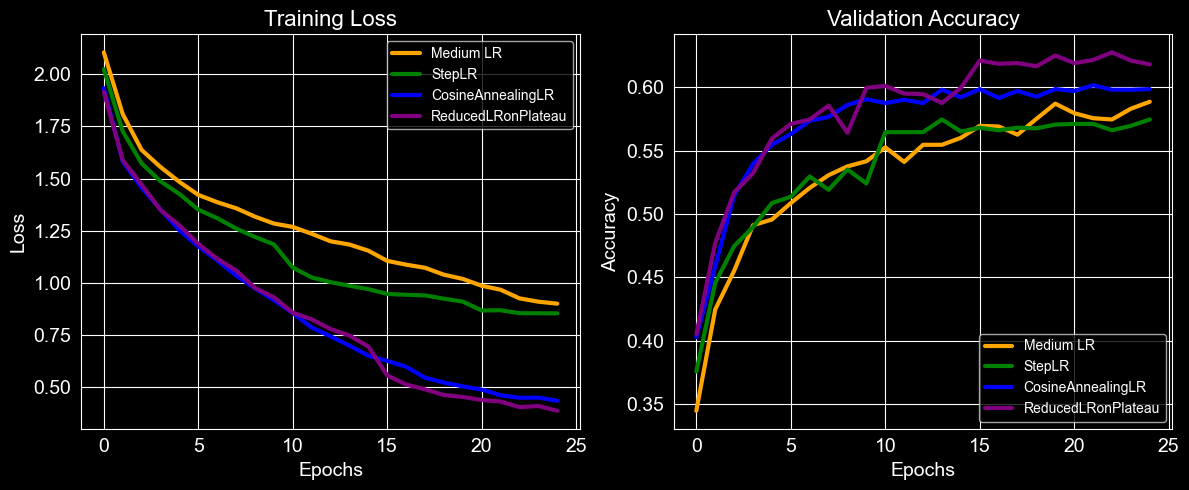

In [14]:
labels = ['Medium LR', 'StepLR', 'CosineAnnealingLR', 'ReducedLRonPlateau']
colors = ['orange', 'green', 'blue', 'purple']

training_curves_new = [history_constant, history_LR, history_cosine, history_plateau]

helper_utils.plot_learning_curves(colors, labels, training_curves_new)

<br>

Upon analyzing the validation accuracy, you see that both the `ReduceLROnPlateau` and `CosineAnnealingLR` schedulers yield improved results when you observe the last epoch. Keep in mind that each scheduler has tunable hyperparameters as well. 

Below, you illustrate how the learning rate changes over the epochs for each scheduler. The `CosineAnnealingLR` scheduler reduces the learning rate according to a cosine decay pattern, while `ReduceLROnPlateau` adjusts it dynamically based on validation performance.

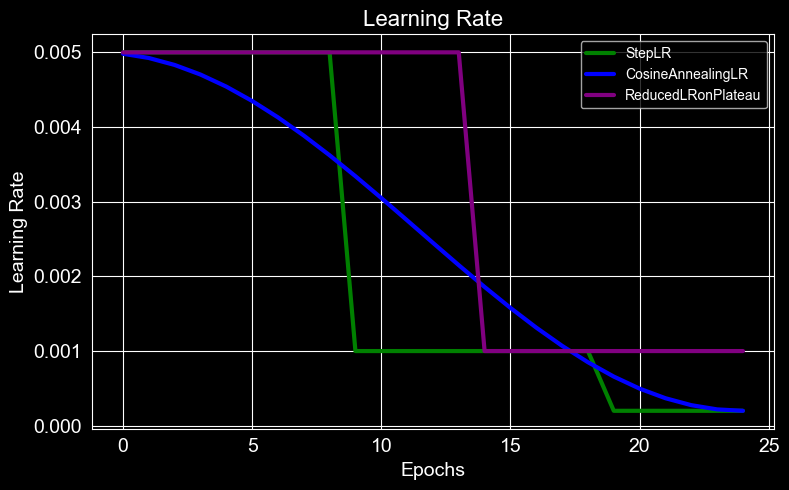

In [15]:
helper_utils.plot_learning_rates_curves(training_curves_new, colors, labels)

<br>

In summary:

- `StepLR` is effective for reducing the learning rate at fixed intervals in a stepwise manner.
- `CosineAnnealingLR` offers a smooth decay without sudden changes, which is beneficial for fine-tuning the model as training concludes. It's particularly advantageous for long training sessions where gradual adjustments can enhance convergence.
- `ReduceLROnPlateau` is useful when validation performance plateaus, as it adjusts the learning rate based on validation metrics, potentially improving generalization. It is responsive to the model's performance, allowing for dynamic adjustments based on training dynamics.

# Conclusion

Congratulations on completing this in-depth exploration of PyTorch's learning rate schedulers! In this notebook, you examined how dynamically adjusting the learning rate can enhance training efficiency, speed up convergence, and improve generalization when compared to a constant learning rate. By utilizing schedulers and visualizing their effects on training and validation metrics, you observed how they contribute to improved model performance. Additionally, you gained valuable experience in tuning scheduler hyperparameters to suit various training scenarios.